# Лабораторная работа 1: Парабола

## Вариант 9

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import ipywidgets as widgets
import warnings

np.set_printoptions(precision=4)

a = 1/120
b = 1/120

l = np.pi

alpha, beta  = 1, -1
gamma, delta = 1, -1

get_left_bound = lambda t : -1 * np.exp(-a*t) * (np.cos(b*t) + np.sin(b*t))
get_right_bound = lambda t : np.exp(-a*t) * (np.cos(b*t) + np.sin(b*t))
get_initial_values = lambda x : np.cos(x)

analit_function = lambda x, t : np.exp(-a*t) * np.cos(x + b*t)


In [2]:
%matplotlib widget

def generate_interaction(function, figure, axis, time_stop, *, w=None):
    x_num_slider = widgets.IntSlider(min=3, max=500, step=1, value=10)
    t_num_slider = widgets.IntSlider(min=3, max=500, step=1, value=200)
    curr_t_slider = widgets.IntSlider(min=3, max=t_num_slider.value, step=1, value=t_num_slider.value)

    # dummy lines
    analyt_line = axis.plot(-2, -2, 4, 4)
    grid_line   = axis.plot(-2, -2, 4, 4)

    @widgets.interact(x_num=x_num_slider, t_num=t_num_slider, curr_t=curr_t_slider)
    def f(x_num, t_num, curr_t):
        curr_t_slider.max = t_num
        if curr_t > t_num:
            curr_t = t_num

        time_step = time_stop / (t_num - 1)
        grid = function(space_stop=l, space_num=x_num, 
                        time_stop=time_stop, time_num=t_num, approx_type='2o3p')

        points = np.linspace(0.0, l, x_num)
        analyt_solution = analit_function(points, (curr_t-1) * time_step)
        grid_solution   = grid[curr_t-1]
        
        error = np.mean( np.square(analyt_solution - grid_solution) )
        print(f"MSError: {error:.10f}")
        
        analyt_line[0].set_data(points, analyt_solution)
        grid_line[0].set_data(points, grid_solution)

## Явный метод

### Алгоритм

In [3]:
def solve_explicit(*, space_start=0.0, space_stop=1.0, space_num=200,
                      time_start=0.0,  time_stop=1.0,  time_num=200,
                      approx_type='1o2p'):
    space_step = (space_stop - space_start) / (space_num - 1)
    time_step = (time_stop - time_start) / (time_num - 1)

    sigma = a * time_step / (space_step*space_step)
    print('Sigma: ', sigma)
    if sigma >= 0.5:
        warnings.warn("Sigma reached 0.5, solution is unstable")
    
    grid = np.zeros((time_num, space_num))
    grid[0, :] = get_initial_values( np.linspace(space_start, space_stop, space_num) )
    
    for t in range(time_num - 1):
        for x in range(1, space_num - 1):
            coef = a * time_step / (space_step*space_step)
            diffusion = coef * ( grid[t, x+1] - 2*grid[t, x] + grid[t, x-1] )
            
            coef = b * time_step / (2*space_step)
            movement = coef * ( grid[t, x+1] - grid[t, x-1] )
            
            grid[t+1, x] = grid[t, x] + diffusion + movement
        
        if approx_type == '1o2p':
            grid[t+1, 0]  = ( -1 * (alpha / space_step) * grid[t+1, 1] + get_left_bound((t+1) * time_step) ) / (beta - alpha / space_step)
            grid[t+1, -1] = ( (gamma / space_step) * grid[t+1, -2] + get_right_bound((t+1) * time_step) ) / (delta + gamma / space_step)
            
        elif approx_type == '2o3p':
            grid[t+1, 0]  = ( get_left_bound((t+1) * time_step) - alpha * (4*grid[t+1, 1] - grid[t+1, 2]) / (2*space_step) ) / ( (-3*alpha)/(2*space_step) + beta )
            grid[t+1, -1] = ( get_right_bound((t+1) * time_step) - gamma * (grid[t+1, -3] - 4*grid[t+1, -2]) / (2*space_step) ) / ( (3*gamma)/(2*space_step) + delta )
            
        elif approx_type == '2o2p':
            # grid[t+1, 0]  = ( get_left_bound((t+1) * time_step)/alpha - )
            grid[t+1, 0]  = (space_step/time_step * grid[t, 0] - get_left_bound((t+1) * time_step) * (2*a*a - b*space_step)/alpha + 2*a*a/space_step * grid[t+1, 1]) / ( 2*a*a/space_step + space_step/time_step + beta/alpha * (2*a*a - b*space_step) )
            grid[t+1, -1] = (space_step/time_step * grid[t, -1] - get_right_bound((t+1) * time_step) * (2*a*a + b*space_step)/gamma + 2*a*a/space_step * grid[t+1, -2]) / (2*a*a/space_step + space_step/time_step + delta/gamma * (2*a*a + b*space_step))
            
    return grid

### Пример решения

interactive(children=(IntSlider(value=10, description='x_num', max=500, min=3), IntSlider(value=200, descripti…

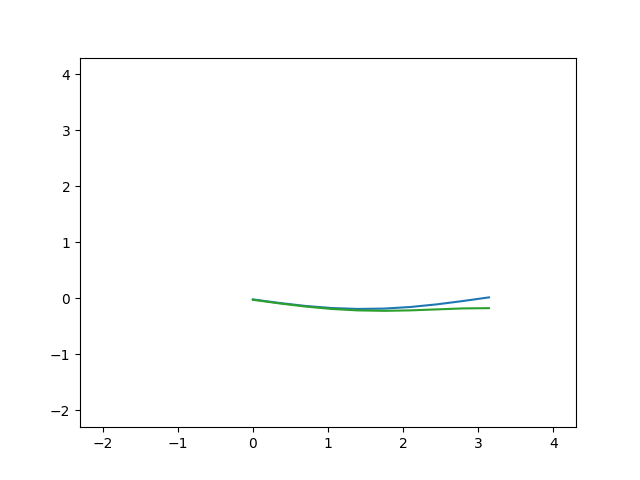

In [4]:
time_stop = 200.0
fig = plt.figure()
ax  = fig.add_subplot(1, 1, 1)

generate_interaction(solve_explicit, fig, ax, time_stop)

## Неявный метод

### Метод прогонки

In [5]:
def solve_tridiagonal(lower, mid, upper, constraints):
    a, b, c, d = map(np.array, (lower, mid, upper, constraints, ))
    x = np.zeros_like(d)
    n = len(d)
    
    for i in range(1, n):
        w = a[i] / b[i - 1]
        b[i] -= w * c[i - 1]
        d[i] -= w * d[i - 1]
    
    x[-1] = d[-1] / b[-1]
    for i in range(n-2, -1, -1):
        x[i] = (d[i] - c[i] * x[i+1]) / b[i]
        
    return x

### Алгоритм

In [6]:
def solve_implicit(*, space_start=0.0, space_stop=1.0, space_num=200,
                      time_start=0.0,  time_stop=1.0,  time_num=200,
                      w = 0.5, approx_type='1o2p'):
    space_step = (space_stop - space_start) / (space_num - 1)
    time_step = (time_stop - time_start) / (time_num - 1)
    
    grid = np.zeros((time_num, space_num))
    grid[0, :] = get_initial_values( np.linspace(space_start, space_stop, space_num) )
    
    for t in range(time_num - 1):
        lower  = np.zeros((space_num, ))
        mid    = np.zeros((space_num, ))
        upper  = np.zeros((space_num, ))
        constr = np.zeros((space_num, ))
        
        lower[1:-1] = w * (a / (space_step*space_step) - b / (2 * space_step))
        mid[1:-1]   = -w * 2 * a / (space_step*space_step) - 1 / time_step
        upper[1:-1] = w * (a / (space_step*space_step) + b / (2 * space_step))
        
        for x in range(1, space_num - 1):
            diff_coef = a / (space_step*space_step)
            move_coef = b / (2 * space_step)
            constr[x] = (w - 1) * ( diff_coef * (grid[t, x+1] - 2 * grid[t, x] + grid[t, x-1]) + move_coef * (grid[t, x+1] - grid[t, x-1]) ) - grid[t, x] / time_step

        if approx_type == '1o2p':
            mid[0]    = beta - alpha / space_step
            upper[0]  = alpha / space_step
            constr[0] = get_left_bound((t+1) * time_step)

            lower[-1]  = -1 * gamma / space_step
            mid[-1]    = delta + gamma / space_step
            constr[-1] = get_right_bound((t+1) * time_step)
            
        elif approx_type == '2o3p':
            first_norm = (-alpha/(2*space_step)) / upper[1]
            mid[0]    = ( (-3*alpha)/(2*space_step) + beta ) - first_norm * lower[1]
            upper[0]  =  (2*alpha)/space_step - first_norm * mid[1]
            constr[0] = get_left_bound((t+1) * time_step) - first_norm * constr[1]
            
            last_norm = gamma/(2*space_step) / lower[-2]
            lower[-1]  = (-2*gamma/space_step) - last_norm * mid[-2]
            mid[-1]    = ( (3*gamma)/(2*space_step) + delta ) - last_norm * upper[-2]
            constr[-1] = get_right_bound((t+1) * time_step) - last_norm * constr[-2]
            

        elif approx_type == '2o2p':
            mid[0]    = 2*a*a/space_step + space_step/time_step - beta/alpha * (2*a*a - b*space_step)
            upper[0]  = -2*a*a/space_step
            constr[0] = space_step/time_step * grid[t, 0] - get_left_bound((t+1) * time_step) * (2*a*a - b*space_step)/alpha
            
            lower[-1]  = -2*a*a/space_step
            mid[-1]    = 2*a*a/space_step + space_step/time_step + delta/gamma * (2*a*a + b*space_step)
            constr[-1] = space_step/time_step * grid[t, -1] + get_right_bound((t+1) * time_step) * (2*a*a + b*space_step)/gamma
            
        grid[t+1] = solve_tridiagonal(lower, mid, upper, constr)
        
    return grid

### Пример решения

interactive(children=(IntSlider(value=10, description='x_num', max=500, min=3), IntSlider(value=200, descripti…

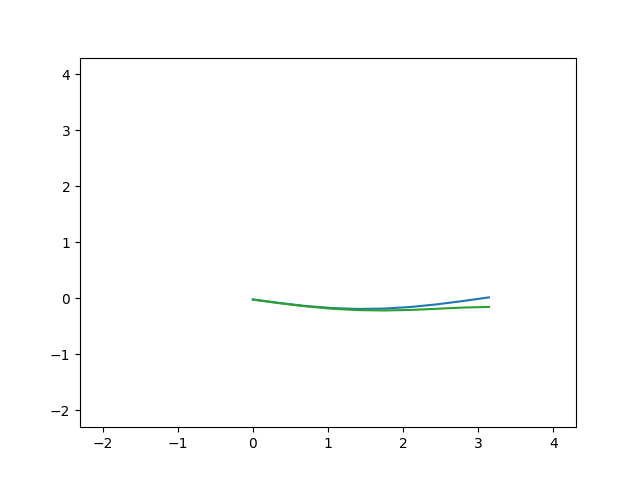

In [7]:
time_stop = 200.0
fig = plt.figure()
ax  = fig.add_subplot(1, 1, 1)

generate_interaction(solve_implicit, fig, ax, time_stop, w=1.0)

## Метод Кранка - Николсона

### Пример решения

interactive(children=(IntSlider(value=10, description='x_num', max=500, min=3), IntSlider(value=200, descripti…

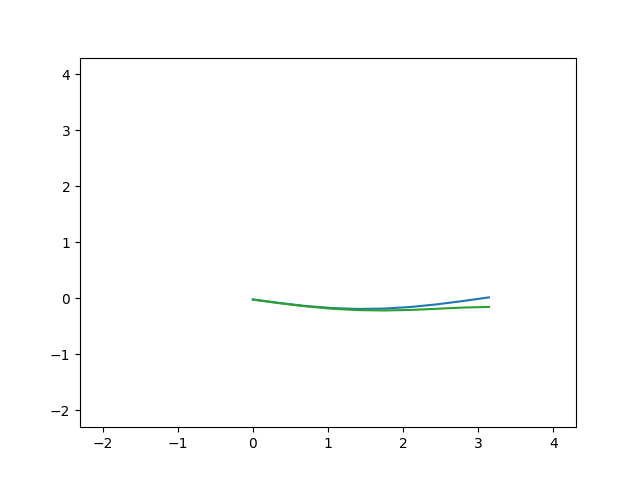

In [8]:
time_stop = 200.0
fig = plt.figure()
ax  = fig.add_subplot(1, 1, 1)

generate_interaction(solve_implicit, fig, ax, time_stop, w=0.5)